****Import all necessary libraries****

In [12]:
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

import tqdm

import seaborn as sns

****Import dataset****

The TuSimple Lane Detection Dataset is a popular dataset used to train and evaluate algorithms for lane detection in autonomous driving systems

In [13]:
data_path = "/kaggle/input/tusimple/TUSimple/train_set"
label_file = "/kaggle/input/tusimple/TUSimple/train_set/label_data_0601.json"

In [14]:
# Load label data from JSON file
with open(label_file, 'r') as f:
    labels = [json.loads(line) for line in f]

# Function to load and preprocess images and generate lane masks
def preprocess_data(data_path, labels, img_size=(256, 256)):
    images = []
    masks = []

    for label in labels:
        # Load and resize the image
        img_path = os.path.join(data_path, label['raw_file'])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image at {img_path}")
            continue
        img = cv2.resize(img, img_size)
        images.append(img)

        # Create a black mask image
        original_mask = np.zeros((720, 1280), dtype=np.uint8)
        lanes = label['lanes']
        h_samples = label['h_samples']

        for lane in lanes:
            points = [(x, y) for x, y in zip(lane, h_samples) if x > 0]
            for i in range(len(points) - 1):
                # Draw white lane lines with width 5
                cv2.line(original_mask, points[i], points[i+1], 255, 5)

        # Resize the mask to match the image size
        resized_mask = cv2.resize(original_mask, img_size)
        masks.append(resized_mask)

    return np.array(images), np.array(masks)

# Run the preprocessing
images, masks = preprocess_data(data_path, labels)

 ****Data Preprocessing: Normalization and Reshaping for Model Input****
 
 **Train-test split:** Divides the dataset into 80% for training and 20% for testing.

**Normalization:** Scales image and mask pixel values from [0, 255] to [0, 1] for better model performance.

**Reshaping:** Adds an extra channel dimension (axis=-1) to the masks, converting them to shape (H, W, 1) — required for models that expect 4D input like (N, C, H, W) after tensor conversion.

In [15]:
x_train_raw, x_test_raw, y_train_raw, y_test_raw = train_test_split(images, masks, test_size=0.2, random_state=42)

x_train = x_train_raw / 255.0
y_train = y_train_raw / 255.0
x_test = x_test_raw / 255.0
y_test = y_test_raw / 255.0

y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [16]:

from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Change shape from (batch, height, width, channels) to (batch, channels, height, width)
x_train_tensor = x_train_tensor.permute(0, 3, 1, 2)
y_train_tensor = y_train_tensor.unsqueeze(1) if y_train_tensor.ndim == 3 else y_train_tensor.permute(0, 3, 1, 2)

x_test_tensor = x_test_tensor.permute(0, 3, 1, 2)
y_test_tensor = y_test_tensor.unsqueeze(1) if y_test_tensor.ndim == 3 else y_test_tensor.permute(0, 3, 1, 2)

# Create TensorDatasets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# DataLoader: batch_size controls how many samples per batch
# shuffle=True randomizes order of data at the beginning of each epoch
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


**ENet-Inspired CNN Architecture**

In [17]:


#Initial Downsampling Block 
class InitialBlock(nn.Module):
    """
    Applies Conv -> BatchNorm -> ReLU -> MaxPool
    """
    def __init__(self, in_channels, out_channels):
        super(InitialBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x, indices = self.maxpool(x)
        return x, indices

# ----- Bottleneck Block -----
class Bottleneck(nn.Module):
    """
    A flexible bottleneck block supporting downsampling, upsampling, and dilation.
    """
    def __init__(self, in_channels, out_channels, dilation=1, downsample=False, upsample=False):
        super(Bottleneck, self).__init__()
        inter_channels = out_channels // 4
        self.downsample = downsample
        self.upsample = upsample

        if downsample:
            self.pool = nn.MaxPool2d(2, stride=2, return_indices=True)
        elif upsample:
            self.upsample_layer = nn.ConvTranspose2d(inter_channels, inter_channels, kernel_size=2, stride=2)
        else:
            self.pool = None
            self.upsample_layer = None

        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
            self.residual_bn = nn.BatchNorm2d(out_channels)
        else:
            self.residual_conv = None

        self.conv1 = nn.Conv2d(in_channels, inter_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(inter_channels)

        self.conv2 = nn.Conv2d(inter_channels, inter_channels, kernel_size=3, padding=dilation,
                               dilation=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_channels)

        self.conv3 = nn.Conv2d(inter_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(0.1)

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))

        if self.downsample:
            x, _ = self.pool(x)
        elif self.upsample:
            x = self.upsample_layer(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(self.bn3(self.conv3(x)))

        if self.residual_conv:
            residual = self.residual_conv(residual)
            residual = self.residual_bn(residual)

        if residual.shape != x.shape:
            residual = F.adaptive_avg_pool2d(residual, x.shape[2:])

        return self.relu(x + residual)

# ----- ENet Architecture -----
class SimpleENet(nn.Module):
    """
    ENet-style encoder-decoder CNN for binary segmentation.
    """
    def __init__(self, num_classes=1):
        super(SimpleENet, self).__init__()
        self.initial_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        # Encoder
        self.encoder = nn.Sequential(
            Bottleneck(16, 64, downsample=True),
            Bottleneck(64, 64),
            Bottleneck(64, 64),
            Bottleneck(64, 64),
            Bottleneck(64, 64),
            Bottleneck(64, 128, downsample=True),
            Bottleneck(128, 128),
            Bottleneck(128, 128),
            Bottleneck(128, 128),
            Bottleneck(128, 128),
            Bottleneck(128, 256, downsample=True),
            Bottleneck(256, 256),
            Bottleneck(256, 256),
            Bottleneck(256, 256),
            Bottleneck(256, 256),
        )

        # Decoder
        self.decoder = nn.Sequential(
            Bottleneck(256, 128, upsample=True),
            Bottleneck(128, 128),
            Bottleneck(128, 128),
            Bottleneck(128, 64, upsample=True),
            Bottleneck(64, 64),
            Bottleneck(64, 64),
            Bottleneck(64, 16, upsample=True),
            Bottleneck(16, 16),
        )

        # Final classifier
        self.classifier = nn.Conv2d(16, num_classes, kernel_size=1)
        self.final_upsample = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=2, stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.initial_block(x)
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.classifier(x)
        x = self.final_upsample(x)
        x = self.sigmoid(x)
        return x

# ----- Model Setup -----
model = SimpleENet(num_classes=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()


In [18]:
def display_result(input_image, ground_truth, model, device):
    # Preprocess input image for the model: (H, W, C) → (1, C, H, W), normalized
    model_input = torch.from_numpy(input_image.transpose(2, 0, 1)).float().div(255.0).unsqueeze(0).to(device)
    
    # Set model to evaluation mode and disable gradient computation
    model.eval()
    with torch.no_grad():
        output = model(model_input)
    
    # Post-process model output
    predicted_mask = output.squeeze().cpu().numpy()
    predicted_mask = (predicted_mask > 0.3).astype(np.uint8) * 255  # Threshold and scale to 0-255
    
    # Create a 3-panel figure
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Show the original input image
    axs[0].imshow(input_image)
    axs[0].set_title("Input Image")
    axs[0].axis('off')
    
    # Show the ground truth mask
    axs[1].imshow(ground_truth, cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis('off')
    
    # Show the predicted lane mask
    axs[2].imshow(predicted_mask, cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [19]:


# Select GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the selected device
model = model.to(device)


In [20]:
epochs = 100

results = {
    'epoch': [],
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        # FIX the shape: remove extra channel if needed
        if y.ndim == 5:
            y = y.squeeze(1)

        optimizer.zero_grad()
        outputs = model(x)

        # Make sure y and output shapes match
        if y.shape != outputs.shape:
            y = F.interpolate(y, size=outputs.shape[2:], mode='nearest')

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

        predicted = (outputs > 0.5).float()
        correct_pixels += (predicted == y).sum().item()
        total_pixels += y.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_pixels / total_pixels

    # ---- TEST ----
    model.eval()
    test_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            if y.ndim == 5:
                y = y.squeeze(1)

            outputs = model(x)

            if y.shape != outputs.shape:
                y = F.interpolate(y, size=outputs.shape[2:], mode='nearest')

            loss = criterion(outputs, y)
            test_loss += loss.item() * x.size(0)

            predicted = (outputs > 0.5).float()
            correct_pixels += (predicted == y).sum().item()
            total_pixels += y.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct_pixels / total_pixels

    results['epoch'].append(epoch + 1)
    results['train_loss'].append(train_loss)
    results['train_accuracy'].append(train_accuracy)
    results['test_loss'].append(test_loss)
    results['test_accuracy'].append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")


Epoch 1/100 | Train Loss: 0.6836, Train Acc: 0.6495 | Test Loss: 0.6666, Test Acc: 0.7378
Epoch 2/100 | Train Loss: 0.6603, Train Acc: 0.7100 | Test Loss: 0.6497, Test Acc: 0.7378
Epoch 3/100 | Train Loss: 0.6440, Train Acc: 0.7284 | Test Loss: 0.6331, Test Acc: 0.7378
Epoch 4/100 | Train Loss: 0.6311, Train Acc: 0.7334 | Test Loss: 0.6199, Test Acc: 0.7378
Epoch 5/100 | Train Loss: 0.6195, Train Acc: 0.7364 | Test Loss: 0.6079, Test Acc: 0.7378
Epoch 6/100 | Train Loss: 0.6077, Train Acc: 0.7369 | Test Loss: 0.5966, Test Acc: 0.7378
Epoch 7/100 | Train Loss: 0.5971, Train Acc: 0.7364 | Test Loss: 0.5875, Test Acc: 0.7379
Epoch 8/100 | Train Loss: 0.5875, Train Acc: 0.7372 | Test Loss: 0.5805, Test Acc: 0.7370
Epoch 9/100 | Train Loss: 0.5775, Train Acc: 0.7375 | Test Loss: 0.5692, Test Acc: 0.7380
Epoch 10/100 | Train Loss: 0.5673, Train Acc: 0.7375 | Test Loss: 0.5599, Test Acc: 0.7379
Epoch 11/100 | Train Loss: 0.5574, Train Acc: 0.7376 | Test Loss: 0.5499, Test Acc: 0.7378
Epoch 12

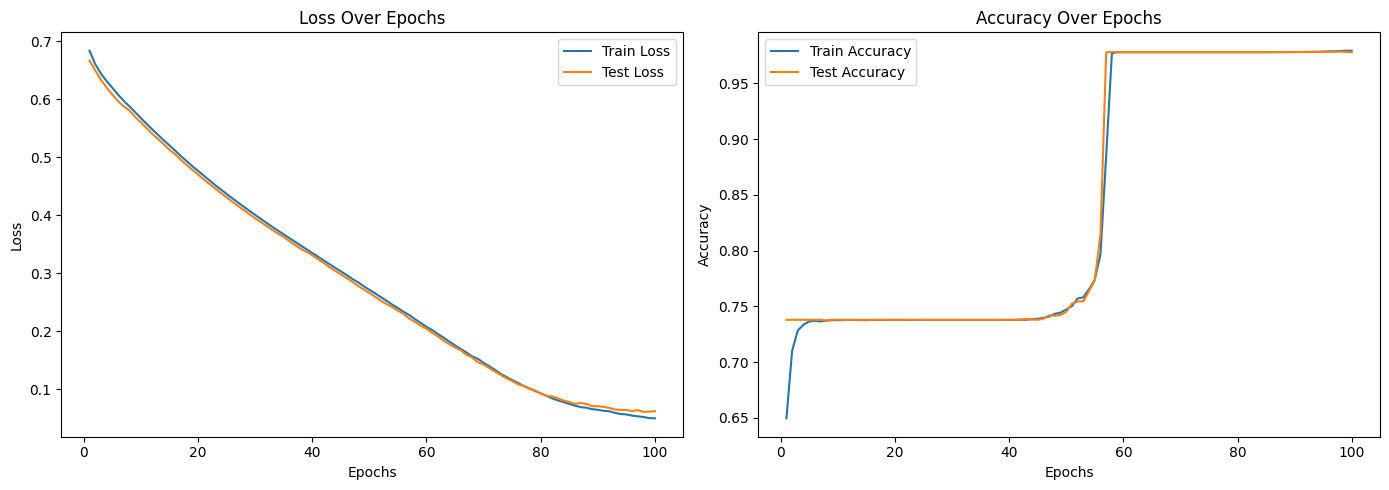

In [21]:

import pandas as pd

# Create DataFrame from results dictionary
results_df = pd.DataFrame(results)

# Extract epochs
epochs = results_df['epoch']

# Plot Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss Plot
ax1.plot(epochs, results_df['train_loss'], label='Train Loss')
ax1.plot(epochs, results_df['test_loss'], label='Test Loss')
ax1.set_title('Loss Over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy Plot
ax2.plot(epochs, results_df['train_accuracy'], label='Train Accuracy')
ax2.plot(epochs, results_df['test_accuracy'], label='Test Accuracy')
ax2.set_title('Accuracy Over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()


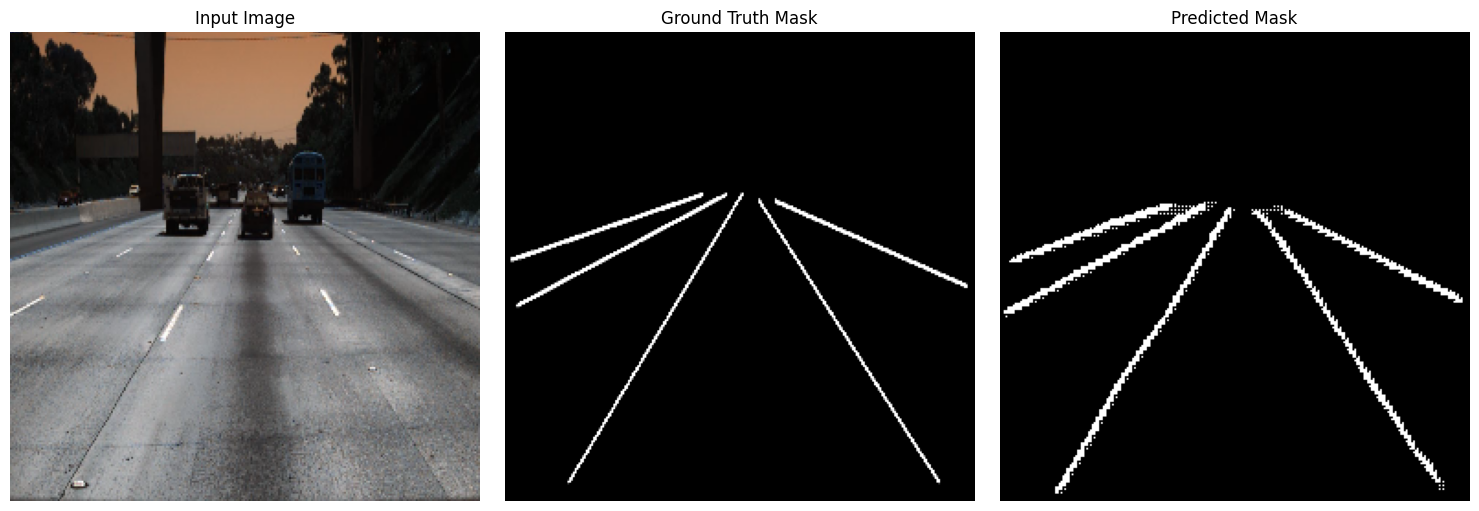

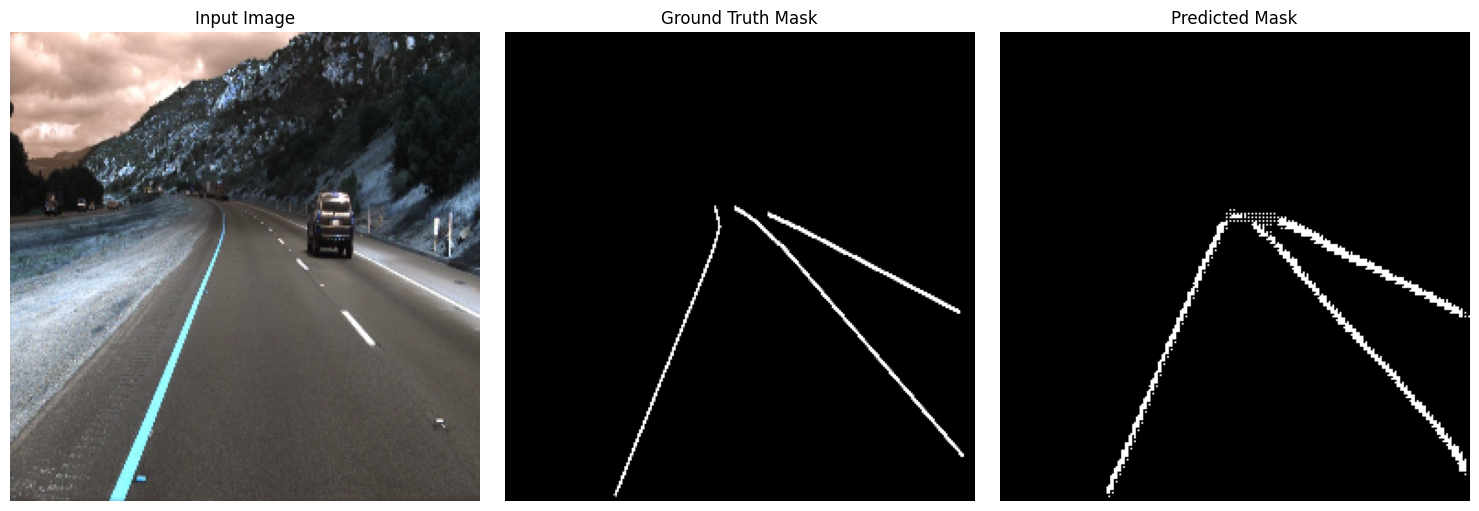

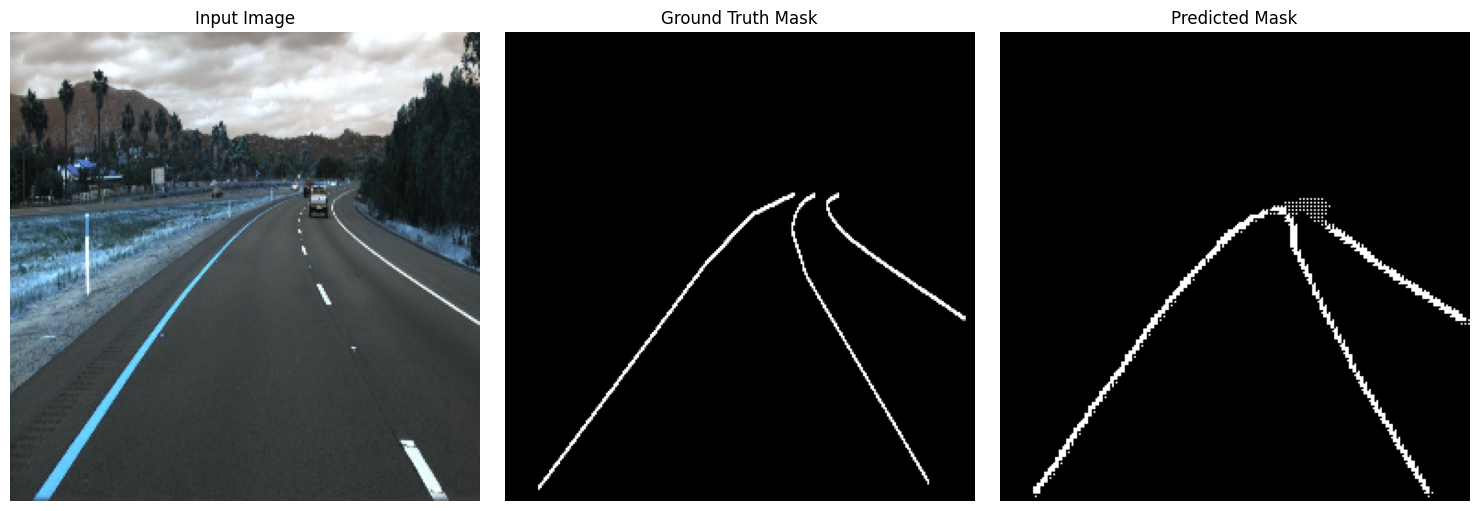

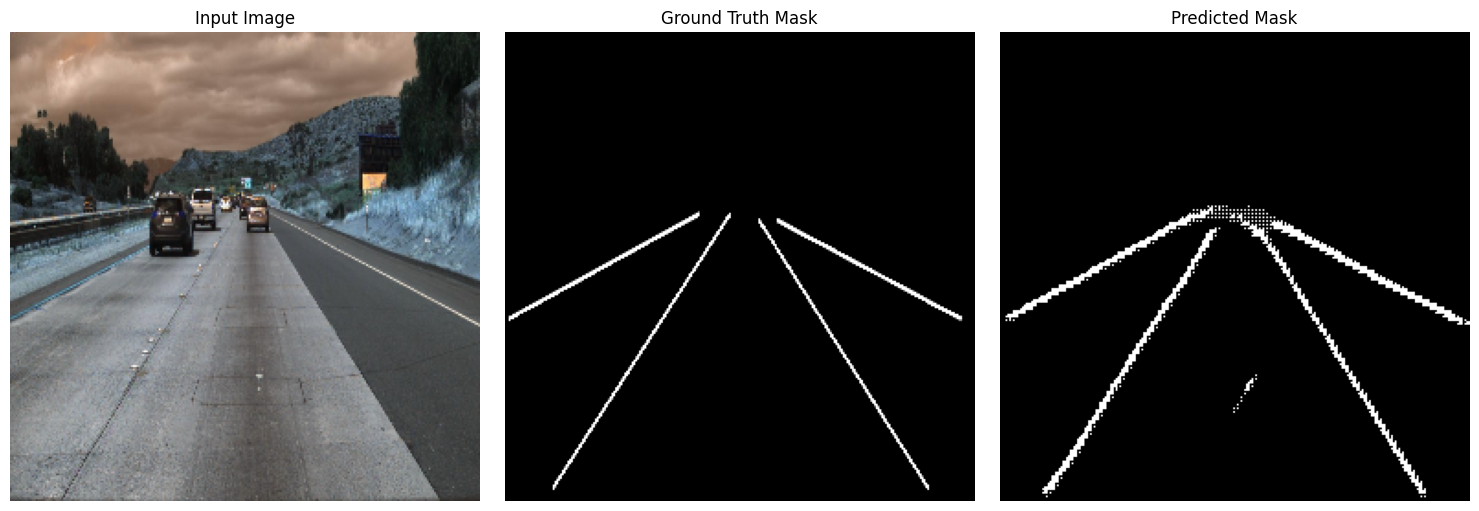

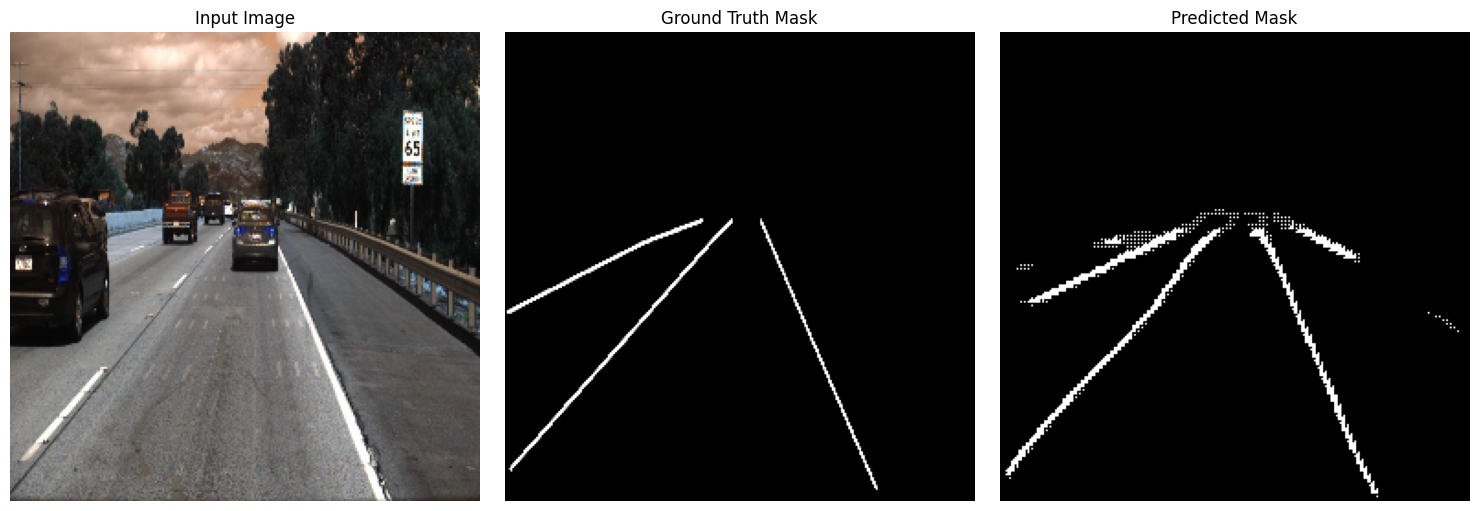

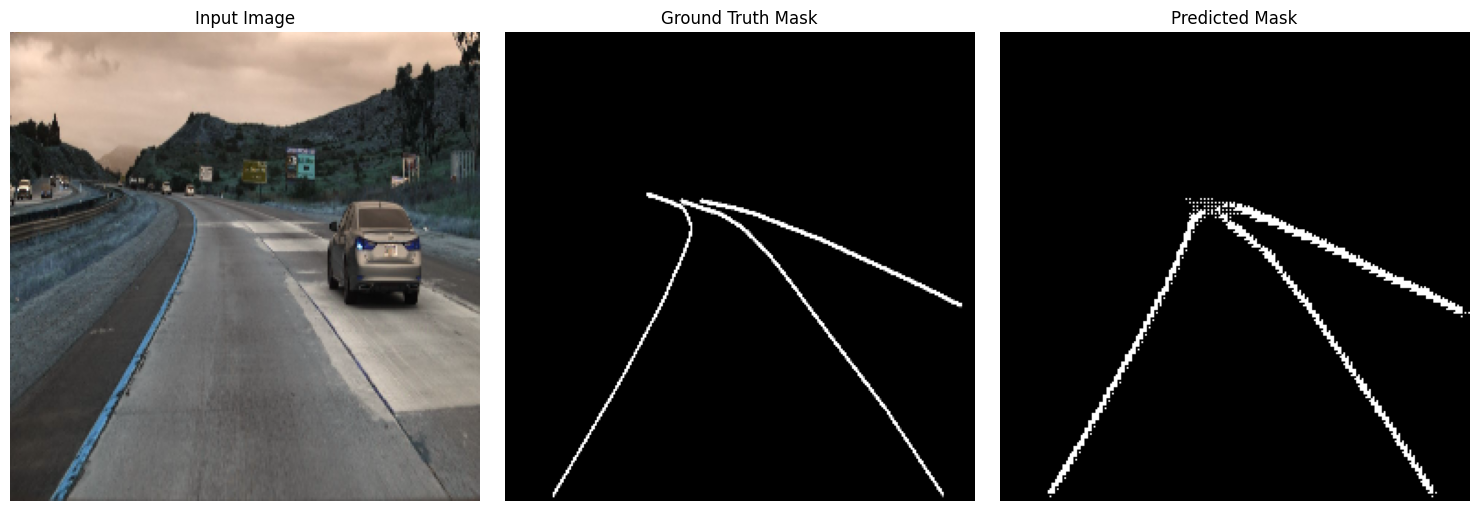

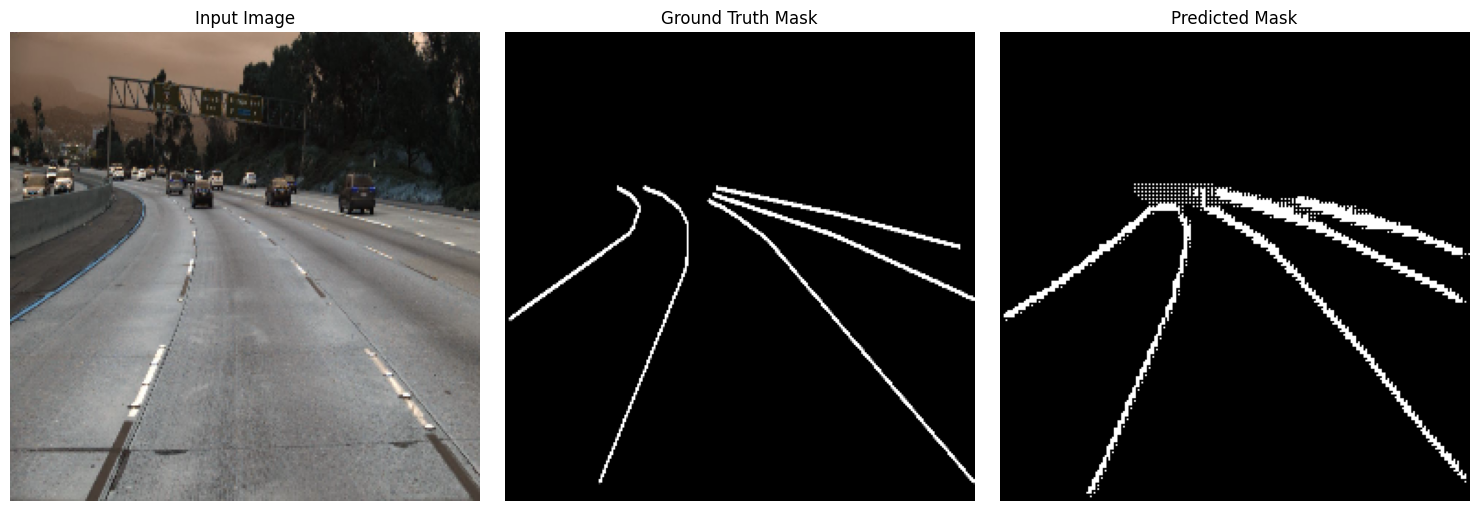

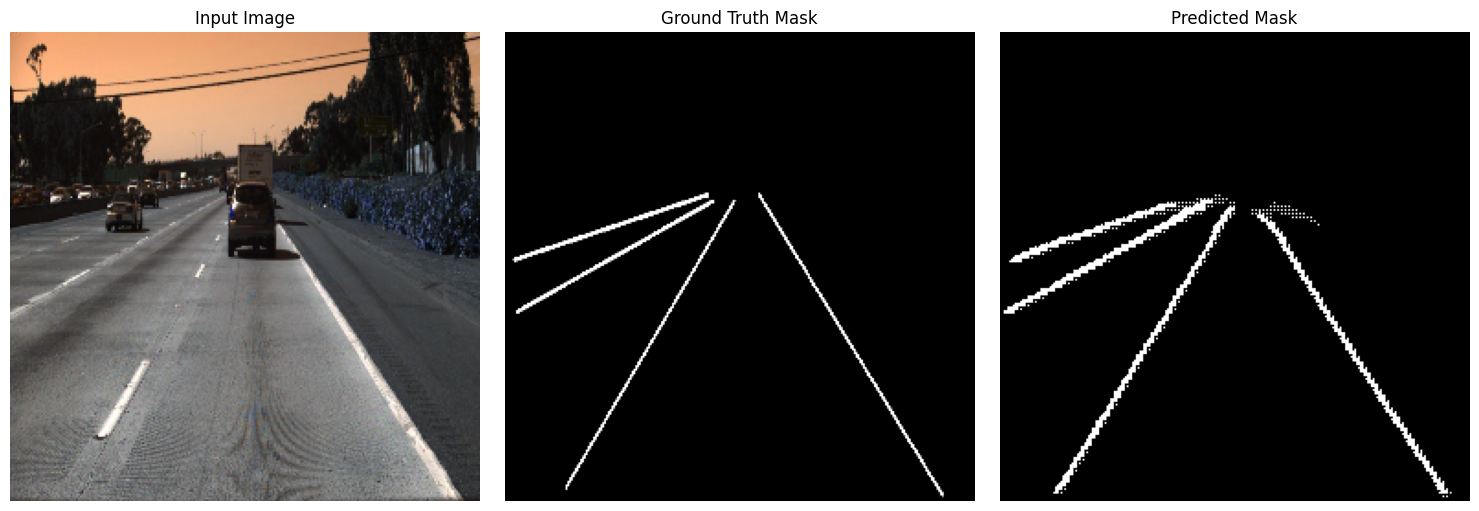

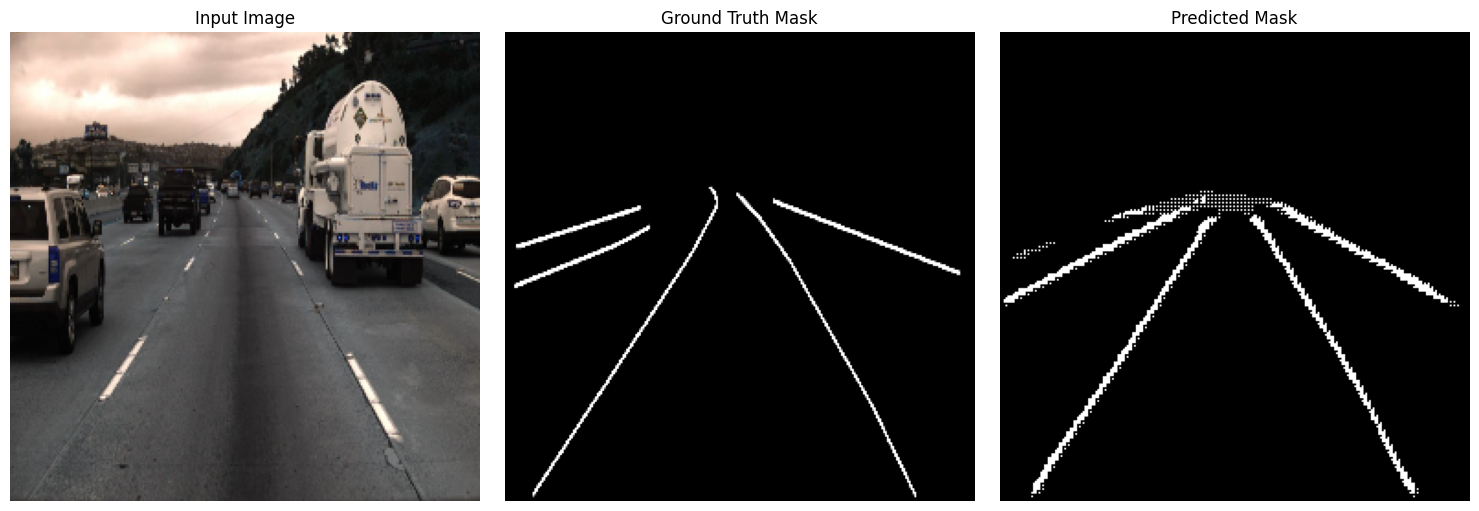

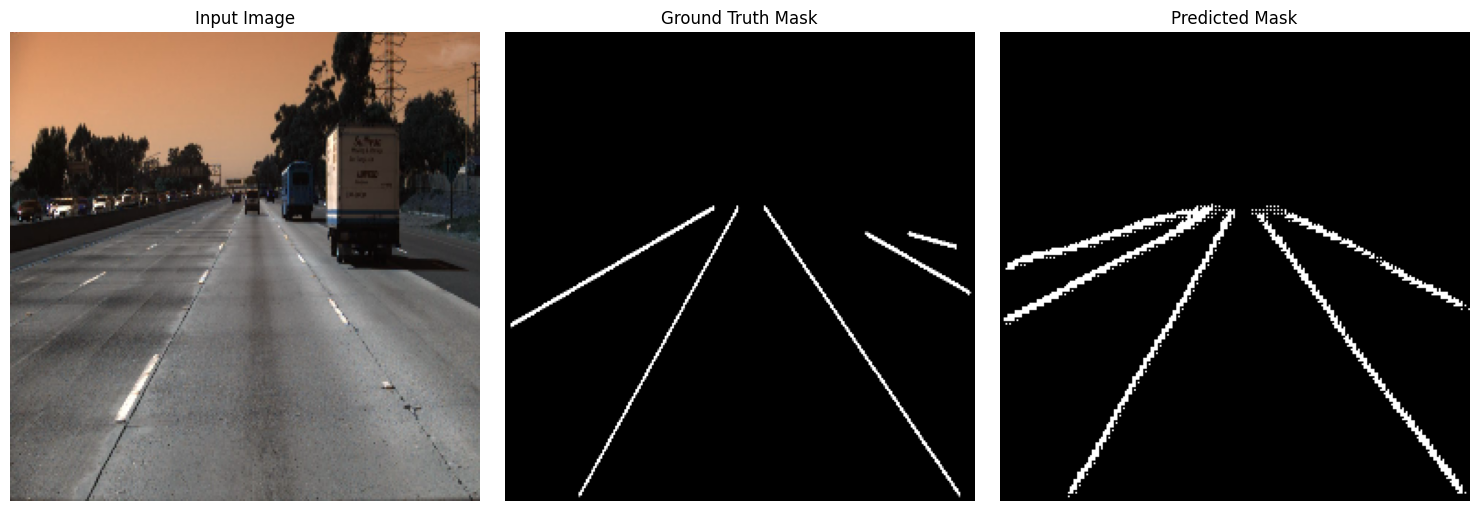

In [22]:
for i in range(10):
    input_image = x_test_raw[i]
    ground_truth = y_test_raw[i].squeeze()  # In case it's (H, W, 1)
    display_result(input_image, ground_truth, model, device)
